In [8]:
# from hmmlearn.hmm import GaussianHMM
from hmmlearn import hmm
import numpy as np
from matplotlib import cm, pyplot as plt
import matplotlib.dates as dates
import pandas as pd
from datetime import timedelta,date

import sklearn
import warnings
warnings.filterwarnings("ignore")

def GHMM_Generate(Sec):
    
    beginDate = '2006-1-1'
    endDate = '2014-12-30'
    n_state = 4

    data_raw = get_price(Sec, start_date = beginDate, end_date=endDate, frequency='daily', fields=['close','volume','money'],fq = "pre")
    
    
    logRet_5 = np.log(np.array(data_raw['close'][5:])) - np.log(np.array(data_raw['close'][:-5]))

    logRet_20 = np.log(np.array(data_raw['close'][20:])) - np.log(np.array(data_raw['close'][:-20]))

    logVol_5 = np.log(np.array(data_raw['volume'][5:])) - np.log(np.array(data_raw['volume'][:-5]))

    logVol_20 = np.log(np.array(data_raw['volume'][20:])) - np.log(np.array(data_raw['volume'][:-20]))

    logMoney_5 = np.log(np.array(data_raw['money'][5:])) - np.log(np.array(data_raw['money'][:-5]))

    logMoney_20 = np.log(np.array(data_raw['money'][20:])) - np.log(np.array(data_raw['money'][:-20]))

    std = pd.rolling_std(data_raw['close'].pct_change(),20)

    data_len = len(data_raw['close']) - 50

    Train_Data = np.column_stack([logRet_5[-data_len:], \
                              logRet_20[-data_len:], \
                              logVol_5[-data_len:], \
                              logVol_20[-data_len:], \
                              logMoney_5[-data_len:], \
                              logMoney_20[-data_len:], \
                              std[-data_len:]])
    
    
    Date = pd.to_datetime(data_raw.index[-data_len:])
    
    model = hmm.GaussianHMM(n_components= n_state, covariance_type="full", n_iter=2000).fit(Train_Data)

    hidden_states = model.predict(Train_Data)
    
    state_pd = pd.concat([pd.DataFrame(Date[-data_len:]),pd.DataFrame(list(hidden_states[-data_len:]))],axis = 1,names = ['date','state'])
    state_pd.columns = ['date','state']

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2008-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2008-10-31", "%Y-%m-%d"))]['state'].value_counts()
    state_BigLoss = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2007-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2007-10-1", "%Y-%m-%d"))]['state'].value_counts()
    state_BigBonus = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2011-1-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2013-1-1", "%Y-%m-%d"))]['state'].value_counts()
    state_MinorLoss = state_choose[state_choose == state_choose.max()].index[0]

    state_choose = state_pd[(state_pd['date'] > datetime.datetime.strptime("2014-6-1", "%Y-%m-%d"))&(state_pd['date'] < datetime.datetime.strptime("2014-12-31", "%Y-%m-%d"))]['state'].value_counts()
    state_MinorBonus = state_choose[state_choose == state_choose.max()].index[0]

    return model,state_BigLoss,state_BigBonus,state_MinorLoss,state_MinorBonus



def single_state_estimation(Sec,model_read,enddate = "2018-12-20"):
    HMM_model = model_read[0]
    state_BigLoss = model_read[1]
    state_BigBonus = model_read[2]
    state_MinorLoss = model_read[3]
    state_MinorBonus =  model_read[4]

    # 生成模型对应的参数
    data_raw = get_price(Sec, count = 100, end_date=enddate, frequency='daily', fields=['close','volume','money'],fq = "pre")

    logRet_5 = np.log(np.array(data_raw['close'][5:])) - np.log(np.array(data_raw['close'][:-5]))

    logRet_20 = np.log(np.array(data_raw['close'][20:])) - np.log(np.array(data_raw['close'][:-20]))

    logVol_5 = np.log(np.array(data_raw['volume'][5:])) - np.log(np.array(data_raw['volume'][:-5]))

    logVol_20 = np.log(np.array(data_raw['volume'][20:])) - np.log(np.array(data_raw['volume'][:-20]))

    logMoney_5 = np.log(np.array(data_raw['money'][5:])) - np.log(np.array(data_raw['money'][:-5]))

    logMoney_20 = np.log(np.array(data_raw['money'][20:])) - np.log(np.array(data_raw['money'][:-20]))

    std = pd.rolling_std(data_raw['close'].pct_change(),20)

    data_len = len(data_raw['close']) - 50


    Train_Data = np.column_stack([logRet_5[-data_len:], \
                                  logRet_20[-data_len:], \
                                  logVol_5[-data_len:], \
                                  logVol_20[-data_len:], \
                                  logMoney_5[-data_len:], \
                                  logMoney_20[-data_len:], \
                                  std[-data_len:]])
    
    

    hidden_states = HMM_model.predict(Train_Data)
    current_states = hidden_states[-1]
    
    if current_states == state_BigLoss:
        return 'bl'
    elif current_states == state_BigBonus:
        return 'bb'
    elif current_states == state_MinorLoss:
        return 'ml'
    elif current_states == state_MinorBonus:
        return 'mb'
    else:
        return 0
    


In [9]:
data_total_pd = pd.read_csv("data_total_pd.csv",index_col = 0)

In [10]:
# 转换为datetime格式
data_total_pd['date'] = data_total_pd.index
data_total_pd
data_total_pd['date'] = pd.to_datetime(data_total_pd['date'])
data_total_pd
data_total_pd.set_index('date',inplace=True)

In [11]:
data_total_pd

,price_raw,price_next,price_diff,state,alpha,score,market_yield,adjust_yield
date,,,,,,,,
2015-01-05,3641.54,3641.06,-0.48,bb,1.0,0.0,-0.000132,0.0
2015-01-06,3641.06,3643.79,2.73,bb,1.0,0.0,0.000750,0.0
2015-01-07,3643.79,3559.26,-84.53,bb,1.0,0.0,-0.023472,0.0
2015-01-08,3559.26,3546.72,-12.54,bb,1.0,0.0,-0.003529,0.0
2015-01-09,3546.72,3513.58,-33.14,bb,1.0,0.0,-0.009388,0.0
2015-01-12,3513.58,3514.04,0.46,bb,1.0,0.0,0.000131,0.0
2015-01-13,3514.04,3502.42,-11.62,bb,1.0,0.0,-0.003312,0.0
2015-01-14,3502.42,3604.12,101.70,bb,1.0,0.0,0.028623,0.0
2015-01-15,3604.12,3635.15,31.03,bb,1.0,0.0,0.008573,0.0


In [12]:
def cal_score(data_total_pd,n,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss):
    # 每个日期进行循环比对
    date_operate = data_total_pd.index
    
    score_list = []
    for date_i in date_operate[:]:

        # 状态的pandas数组
        States_pd_current = data_total_pd[(data_total_pd.index <= date_i)&(data_total_pd.index > (date_i - timedelta(days = n)))]

        score_current = 0
        for index, row in States_pd_current.iterrows():
            if row['state'] == "bb":
                score_current += score_BigBonus
            elif row['state'] == "bl":
                score_current += score_BigLoss
            elif row['state'] == "mb":
                score_current += score_MinorBonus
            elif row['state'] == "ml":
                score_current += score_MinorLoss
        score_list.append(score_current)

    data_total_pd['score'] = np.array(score_list)
    return data_total_pd


In [27]:
n_windows = 20
score_BigBonus =  2
score_BigLoss = -4
score_MinorBonus = 6
score_MinorLoss = -10

total_score = 10

In [28]:
data_total_pd = cal_score(data_total_pd,n_windows,score_BigBonus,score_BigLoss,score_MinorBonus,score_MinorLoss)

data_total_pd['alpha'] = np.where(data_total_pd['score'] > 0,data_total_pd['score']/total_score,0)

data_total_pd['adjust_yield'] =  \
        np.log( 1 + data_total_pd['alpha'] * data_total_pd['price_diff'] / data_total_pd['price_raw'])

# 避免后续出错
data_total_pd.fillna(0,inplace = True)

# 计算胜率
win_rate = \
    float(sum(data_total_pd['adjust_yield'] > data_total_pd['market_yield'])) / float(len(data_total_pd['adjust_yield']))


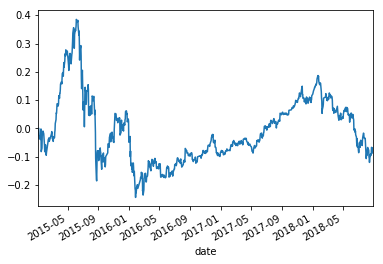

In [29]:
market_yield = np.cumsum(data_total_pd['market_yield'])

# 画图
market_yield.plot()

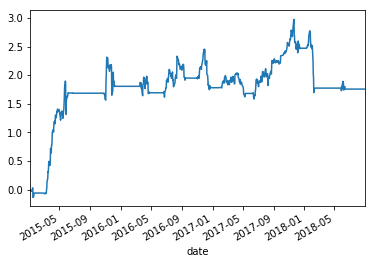

In [30]:
portfolio_yield = np.cumsum(data_total_pd['adjust_yield'])

# 画图
portfolio_yield.plot()

In [36]:
xx = np.ones(data_total_pd.shape[0])

list(data_total_pd['adjust_yield'] > data_total_pd['market_yield'])
xx[list(data_total_pd['adjust_yield'] > data_total_pd['market_yield'])]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1